In [1]:
# Setup our notebook environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pdb
%matplotlib inline

from IPython.display import HTML

In [2]:
# Common Python Library
lib_directory = "/raid/baldwin/code/people-tracking/lib"

# Models Directory
model_directory = "/raid/baldwin/code/people-tracking/models/"

import sys

# Current Path Information
previous_path_length = len(sys.path)

sys.path.insert(0, lib_directory)
sys.path.insert(0, model_directory)

# New Path Information
new_path_length = len(sys.path)

print("Path length: {}->{}".format(previous_path_length, new_path_length))

Path length: 10->12


In [3]:
from common.abstract.data import Image, Color
from human.classifier import HumanPresenceClassifier, CLASSES

HumanPresenceClassifier.saver_state_file = "/raid/baldwin/code/people-tracking/models/human/VGGnet_fast_rcnn_iter_150000.ckpt"

classifier = HumanPresenceClassifier()

person_class_index = CLASSES.index('person')

# Helpful utilities

def show_image(image, plot_title=''):
    plt.figure()
    plt.title(plot_title)
    plt.imshow(image.get_np_array())

Tensor("Placeholder:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("conv5_3/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_conv/3x3/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_cls_score/BiasAdd:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_cls_prob:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("Reshape_2:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_bbox_pred/BiasAdd:0", shape=(?, ?, ?, 36), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 3), dtype=float32)
Tensor("conv5_3/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rois:0", shape=(?, 5), dtype=float32)
[<tf.Tensor 'conv5_3/Relu:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'rois:0' shape=(?, 5) dtype=float32>]
Tensor("fc7/fc7:0", shape=(?, 4096), dtype=float32)
INFO:tensorflow:Restoring parameters from /raid/baldwin/code/people-tracking/models/human/VGGnet_fast_rcnn_iter_150000.ckpt


In [4]:
def get_spaced_colors(N):
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]

    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

# Fast RCNN

In [5]:
from common.abstract.machine_learning.result.objects import SpatialResult
from common.utils.data_manipulation import parse_bounding_box

from common.abstract.cartesian import Coordinate
from common.abstract.shapes import Rectangle

def classify_and_annotate_image(image, only_persons=True):
    image_classifications = classifier.classify(image)
    return annotate_image(image, image_classifications, only_persons)


def annotate_image(image, classifications, only_persons=False):
    if only_persons:
        spatial_results = classifications.get('person', list())
        image = draw_spatial_results_on_image(image, spatial_results=spatial_results)
        return image
    
    for class_label in classifications.keys():
        spatial_results = classifications.get(class_label, list())
        image = draw_spatial_results_on_image(image, spatial_results=spatial_results)
    return image


def get_person_boxes_and_scores(image):
    object_proposals = classifier.detect_object_proposals(image.cv2_encode())
    boxes = object_proposals.get_boxes_for_class_index(person_class_index)
    scores = object_proposals.get_scores_for_class_index(person_class_index)
    return boxes, scores


def threshold_proposals(flattened, threshold=0.85):
    indices_above_threshold = np.where(flattened[:, -1] >= threshold)[0]
    reduced_proposals = flattened_vector[indices_above_threshold]
    return reduced_proposals


def threshold_bounds_proposals(flattened, threshold_lower=0.85, threshold_upper=0.95):
    indices_above_threshold = np.where(flattened[:, -1] >= threshold_lower)[0]
    reduced_proposals = flattened_vector[indices_above_threshold]
    indices_below_threshold = np.where(reduced_proposals[:, -1] <= threshold_upper)[0]
    return reduced_proposals[indices_below_threshold]

def proposals_to_spatial_results(proposals, label='person'):
    results = list()
    for proposal in proposals:
        x_top, y_top, x_bottom, y_bottom = proposal[:4]
        score = proposal[-1]
        
        x_top, y_top, width, height = parse_bounding_box(x_top, y_top, x_bottom, y_bottom)
        shape = Rectangle(width=width, height=height)
        origin = Coordinate(x_top, y_top)
        spatial_result = SpatialResult(label=label, score=score, shape=shape, origin=origin)
        
        results.append(spatial_result)
    return results


def draw_spatial_results_on_image(image, spatial_results):
    annotated_image = image
    
    n_spatial_results = len(spatial_results)
    colors = [Color(red=c[0], green=c[1], blue=c[2]) for c in get_spaced_colors(n_spatial_results)]

    for i, result in enumerate(spatial_results):
        drawer = result.get_drawable(color=colors[i])
        annotated_image = drawer.draw(annotated_image)

    return annotated_image

# Selective Search

In [6]:
# -*- coding: utf-8 -*-
from __future__ import division

import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation


# "Selective Search for Object Recognition" by J.R.R. Uijlings et al.
#
#  - Modified version with LBP extractor for texture vectorization


def _generate_segments(im_orig, scale, sigma, min_size):
    """
        segment smallest regions by the algorithm of Felzenswalb and
        Huttenlocher
    """

    # open the Image
    im_mask = skimage.segmentation.felzenszwalb(
        skimage.util.img_as_float(im_orig), scale=scale, sigma=sigma,
        min_size=min_size)

    # merge mask channel to the image as a 4th channel
    im_orig = np.append(
        im_orig, np.zeros(im_orig.shape[:2])[:, :, np.newaxis], axis=2)
    im_orig[:, :, 3] = im_mask

    return im_orig


def _sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def _sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def _sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize


def _calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2) + _sim_texture(r1, r2)
            + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))


def _calc_colour_hist(img):
    """
        calculate colour histogram for each region

        the size of output histogram will be BINS * COLOUR_CHANNELS(3)

        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]

        extract HSV
    """

    BINS = 25
    hist = np.array([])

    for colour_channel in (0, 1, 2):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(c, BINS, (0.0, 255.0))[0]])

    # L1 normalize
    hist = hist / len(img)

    return hist


def _calc_texture_gradient(img):
    """
        calculate texture gradient for entire image

        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.

        output will be [height(*)][width(*)]
    """
    ret = np.zeros((img.shape[0], img.shape[1], img.shape[2]))

    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret


def _calc_texture_hist(img):
    """
        calculate texture histogram for each region

        calculate the histogram of gradient for each colours
        the size of output histogram will be
            BINS * ORIENTATIONS * COLOUR_CHANNELS(3)
    """
    BINS = 10

    hist = np.array([])

    for colour_channel in (0, 1, 2):

        # mask by the colour channel
        fd = img[:, colour_channel]

        # calculate histogram for each orientation and concatenate them all
        # and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(fd, BINS, (0.0, 1.0))[0]])

    # L1 Normalize
    hist = hist / len(img)

    return hist


def _extract_regions(img):

    R = {}

    # get hsv image
    hsv = skimage.color.rgb2hsv(img[:, :, :3])

    # pass 1: count pixel positions
    for y, i in enumerate(img):

        for x, (r, g, b, l) in enumerate(i):

            # initialize a new region
            if l not in R:
                R[l] = {
                    "min_x": 0xffff, "min_y": 0xffff,
                    "max_x": 0, "max_y": 0, "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y

    # pass 2: calculate texture gradient
    tex_grad = _calc_texture_gradient(img)

    # pass 3: calculate colour histogram of each region
    for k, v in list(R.items()):

        # colour histogram
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        R[k]["size"] = len(masked_pixels / 4)
        R[k]["hist_c"] = _calc_colour_hist(masked_pixels)

        # texture histogram
        R[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])

    return R


def _extract_neighbours(regions):

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours


def _merge_regions(r1, r2):
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (
            r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (
            r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        #####can there be two pairs of labels whose sum is equal? that would mean overwriting!
        #####no problem. the labels are lists to start with, so they just get appended.
        "labels": r1["labels"] + r2["labels"]
    }
    return rt


def selective_search_local(
        im_orig, scale=1.0, sigma=0.8, min_size=50):
    '''Selective Search

    Parameters
    ----------
        im_orig : ndarray
            Input image
        scale : int
            Free parameter. Higher means larger clusters in felzenszwalb segmentation.
        sigma : float
            Width of Gaussian kernel for felzenszwalb segmentation.
        min_size : int
            Minimum component size for felzenszwalb segmentation.
    Returns
    -------
        img : ndarray
            image with region label
            region label is stored in the 4th value of each pixel [r,g,b,(region)]
        regions : array of dict
            [
                {
                    'rect': (left, top, width, height),
                    'labels': [...],
                    'size': component_size
                },
                ...
            ]
    '''
    assert im_orig.shape[2] == 3, "3ch image is expected"

    # load image and get smallest regions
    # region label is stored in the 4th value of each pixel [r,g,b,(region)]
    img = _generate_segments(im_orig, scale, sigma, min_size)

    if img is None:
        return None, {}

    imsize = img.shape[0] * img.shape[1]
    
    R = _extract_regions(img)

    # extract neighbouring information
    neighbours = _extract_neighbours(R)

    # calculate initial similarities
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = _calc_sim(ar, br, imsize)

    # hierarchal search
    while S != {}:

        # get highest similarity
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # merge corresponding regions
        t = max(R.keys()) + 1.0
        R[t] = _merge_regions(R[i], R[j])

        # mark similarities for regions to be removed
        key_to_delete = []
        for k, v in list(S.items()):
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # remove old similarities of related regions
        for k in key_to_delete:
            del S[k]

        # calculate similarity set with the new region
        for k in [a for a in key_to_delete if a != (i, j)]:
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = _calc_sim(R[t], R[n], imsize)

    regions = []
    for k, r in list(R.items()):
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
            'size': r['size'],
            'labels': r['labels']
        })

    return img, regions

# Bringing it together

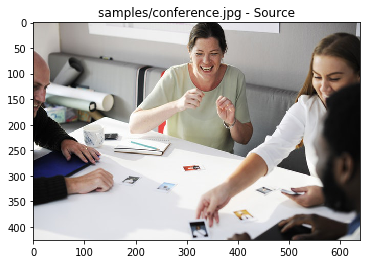

In [7]:
#image_path = "samples/lunch.jpg"
#image_path = "samples/referees_cropped.jpg"

#image_path = "samples/hugging.jpg"

#image_path = "samples/happy.jpg"
#image_path = "samples/rock.jpg"

image_path = "samples/conference.jpg"
image = Image.from_file(image_path)
show_image(image, '{} - Source'.format(image_path))

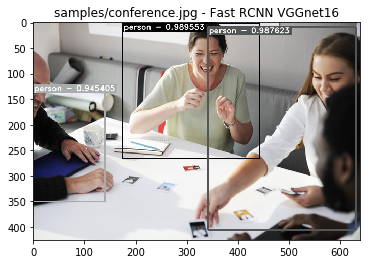

In [8]:
classifications = classifier.classify(image)
show_image(annotate_image(image, classifications, only_persons=True), '{} - Fast RCNN VGGnet16'.format(image_path))

In [9]:
boxes, scores = get_person_boxes_and_scores(image)

flattened_vector = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32)

In [10]:
spatial_results_all = proposals_to_spatial_results(flattened_vector)

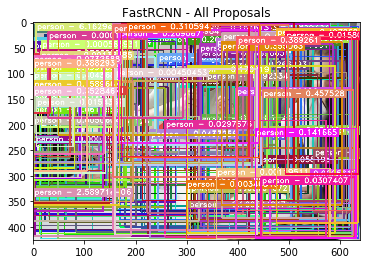

In [11]:
show_image(draw_spatial_results_on_image(image, spatial_results=spatial_results_all), 'FastRCNN - All Proposals')

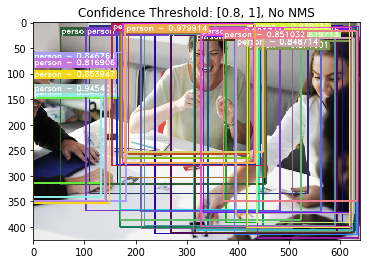

In [12]:
confidence_threshold_lower = 0.8
confidence_threshold_upper = 1

proposals = threshold_bounds_proposals(flattened_vector, confidence_threshold_lower, confidence_threshold_upper)
spatial_results = proposals_to_spatial_results(proposals)

show_image(draw_spatial_results_on_image(image, spatial_results=spatial_results), 'Confidence Threshold: [{}, {}], No NMS'.format(confidence_threshold_lower, confidence_threshold_upper))

In [13]:
def show_ss_map(img_lbl):
    h = img_lbl.shape[0]
    w = img_lbl.shape[1]
    seg = np.zeros([h,w,3])

    for i in range(h):
        for j in range(w):

            color_label = int(img_lbl[i][j][3])
            seg[i][j][0]= unique_colors[color_label][0]
            seg[i][j][1]= unique_colors[color_label][1]
            seg[i][j][2]= unique_colors[color_label][2]




    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(seg)
    plt.show()

def show_ss_image(img, regions):
    candidates = []
    for r in regions:
        # excluding same rectangle (with different segments)
        #if r['rect'] in candidates:
            #continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 1000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 10 or h / w > 10:
            continue
        candidates.append([r['rect'], r['labels']])

    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    inx = 0 
    for rectangle, label in candidates:
        #print(x, y, w, h)
        x,y,w,h = rectangle

        delt = 0
        for l in label:     
            #unique_colors[]
            this_label = int(l)
            edgecolor = [unique_colors[this_label][0]/255, unique_colors[this_label][1]/255, unique_colors[this_label][2]/255]
            #add slight offset to visualize each segment label that consitutes this region
            rect = mpatches.Rectangle((x+delt, y+delt), w, h, fill=False, edgecolor=edgecolor, linewidth=1)
            #delt = delt + 1
            ax.add_patch(rect)

    plt.show()

In [14]:
image_np = image.get_np_array()

labels, regions = selective_search_local(image_np, scale=500, sigma=0.8, min_size=10)

n_colors = len(np.unique(labels[:,:,3]))
unique_colors = get_spaced_colors(n_colors)

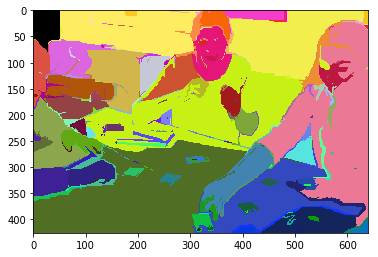

In [15]:
show_ss_map(labels)

In [16]:
from collections import defaultdict

def area_of_labels(labels):
    h = labels.shape[0]
    w = labels.shape[1]
    
    area = defaultdict(int)
    
    for i in range(h):
        for j in range(w):
            label = labels[i][j][-1]
            area[label] += 1
            
    return area

def regions_contained(proposals, labels):
    regions = defaultdict(lambda: defaultdict(int))
    
    for proposal in proposals:
        x_top, y_top, x_bottom, y_bottom = proposal[:4]
        region = (x_top, y_top, x_bottom, y_bottom)
        
        w = int(x_bottom - x_top)
        h = int(y_bottom - y_top)
        
        for i in range(h):
            i = int(i + y_top)
            for j in range(w):
                j = int(j + x_top)
                label = labels[i][j][-1]
                regions[region][label] += 1

    return regions

In [17]:
import time
def timeit(method):

    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print '%r (%r, %r) %2.5f sec' % \
              (method.__name__, args, kw, te-ts)
        return result

    return timed

@timeit
def timethis():
    regions_contained(proposals, labels)

#timethis()

In [18]:
def _image_segments(im, scale=500, sigma=0.8, min_size=10):
    """
        segment smallest regions by the algorithm of Felzenswalb and
        Huttenlocher
    """
    
    image_segments = skimage.segmentation.felzenszwalb(
        skimage.util.img_as_float(im), scale=scale, sigma=sigma,
        min_size=min_size)

    #print np.unique(im_mask), np.unique(im_mask, return_counts=True), im_mask.shape
    return image_segments
    # merge mask channel to the image as a 4th channel
    #im_orig = np.append(
    #    im_orig, np.zeros(im_orig.shape[:2])[:, :, np.newaxis], axis=2)
    #im_orig[:, :, 3] = im_mask
    
    #return im_masks
 
# Malisiewicz et al.
def non_max_suppression_fast(boxes, proposal_segments, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type

    return boxes[pick].astype("int")

def _reduce_proposals(p1, p2, P, G, threshold=0.8):
    p_lg = p1 if P[p1][1] > P[p2][1] else p2
    p_sm = p1 if P[p1][1] <= P[p2][1] else p2
    
    p_lg_t = P[p_lg]
    p_sm_t = P[p_sm]
    
    p_lg_count, p_lg_size, p_lg_seg = p_lg_t
    p_sm_count, p_sm_size, p_sm_seg = p_sm_t
    
    # Sets
    P_LG = set(p_lg_seg)
    P_SM = set(p_sm_seg)
    
    # is P_SM fully enveloped by P_LG?
    if P_SM.issubset(P_LG):
        G[p_lg] = G[p_sm]
    
    return G

def _proposal_segments(proposals, image_segments, threshold=0.8):
    P = list()
    
    segment_indices, segment_counts = np.unique(image_segments, return_counts=True)
    
    for proposal in proposals:
        x_top, y_top, x_bottom, y_bottom = [int(c) for c in proposal[:4]]
        w = x_bottom - x_top
        h = y_bottom - y_top
        size = w * h
        
        # Each pixel has an assigned segment
        proposal_segments = image_segments[y_top:y_bottom, x_top:x_bottom]
        
        # Get the unique segments and their count
        segments, count =  np.unique(proposal_segments, return_counts=True)
        
        # Percentage of the captured segment within our proposal
        percentage = count / segment_counts[segments]
        
        # Segments that are above the specified area threshold (proposal contains 80% of that segment)
        threshold_indices = np.where(percentage >= threshold)
        thresholded_count = count[threshold_indices] 
        thresholded_segments = segments[threshold_indices]
        #print percentage[np.where(percentage >= threshold)]
        
        P.append((thresholded_count, size, thresholded_segments))
        

    return P

def _is_box_disjoint(p1_coords, p2_coords):
    p1_x_top, p1_y_top, p1_x_bottom, p1_y_bottom = p1_coords
    p2_x_top, p2_y_top, p2_x_bottom, p2_y_bottom = p2_coords
    
    return (p1_x_bottom <= p2_x_top and p1_y_bottom >= p2_y_top) or (p2_x_bottom <= p1_x_top and p2_y_bottom >= p1_y_top)

def _intersecting_pairs(proposals):
    # Pair proposals only if they intersect
    pairs = []
    for i, p1 in enumerate(proposals):
        p1_coords = [int(c) for c in p1[:4]]
        for j, p2 in enumerate(proposals[i+1:]):
            j += i+1
            p2_coords = [int(c) for c in p2[:4]]
            if not _is_box_disjoint(p1_coords, p2_coords):
                pairs.append((i, j))
    
    return pairs

def _proposal_groups(P, proposals, threshold=0.8):
    pairs = _intersecting_pairs(proposals)  
    
    # Groups
    G = np.array(range(len(P)))
    for pair in pairs:
        p1, p2 = pair
        G = _reduce_proposals(p1, p2, P, G, threshold)
            
    return G


    
@timeit
def timethis():
    image_segments = _image_segments(image_np)
    proposal_segments = _proposal_segments(proposals, image_segments)
    proposal_groups = _proposal_groups(proposal_segments, proposals)

    #unique_proposals =  proposals[np.unique(proposal_groups)]
    #unique_spatial_results = proposals_to_spatial_results(unique_proposals)

#timethis()

In [19]:
image_segments = _image_segments(image_np)
proposal_segments = _proposal_segments(proposals, image_segments)

proposal_groups = _proposal_groups(proposal_segments, proposals)

proposal_indices_pre_nms = np.unique(proposal_groups) 
unique_proposals =  proposals[proposal_indices_pre_nms]
unique_spatial_results = proposals_to_spatial_results(unique_proposals)

print proposal_groups

[39 39 38 39 33 39 12 39  8 33 33 22 12 33 14 15 39 17 18 19 20 21 22 17 29
 22 22 17 17 29 22 31 17 33 34 29 22 33 38 22 17]


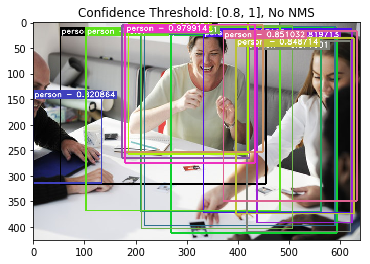

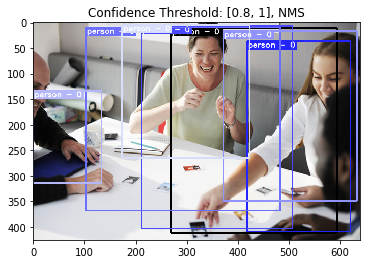

In [23]:
nms_unique_proposals = non_max_suppression_segmentbased(unique_proposals, proposal_indices_pre_nms, 
                                                        proposal_segments, 0.75, 0.4)
nms_unique_spatial_results = proposals_to_spatial_results(nms_unique_proposals)  

show_image(draw_spatial_results_on_image(image, spatial_results=unique_spatial_results), 'Confidence Threshold: [{}, {}], No NMS'.format(confidence_threshold_lower, confidence_threshold_upper))
show_image(draw_spatial_results_on_image(image, spatial_results=nms_unique_spatial_results), 'Confidence Threshold: [{}, {}], NMS'.format(confidence_threshold_lower, confidence_threshold_upper))

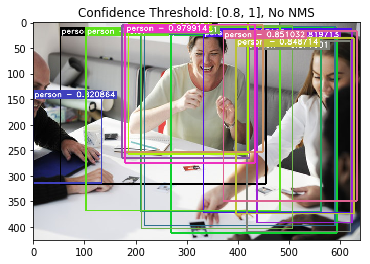

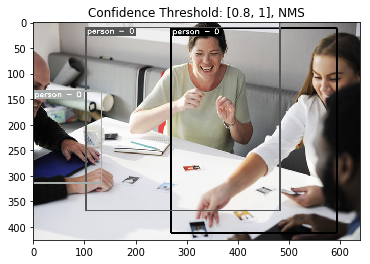

In [24]:
nms_unique_proposals = non_max_suppression_fast(unique_proposals, proposal_segments, 0.75)
nms_unique_spatial_results = proposals_to_spatial_results(nms_unique_proposals)  

show_image(draw_spatial_results_on_image(image, spatial_results=unique_spatial_results), 'Confidence Threshold: [{}, {}], No NMS'.format(confidence_threshold_lower, confidence_threshold_upper))
show_image(draw_spatial_results_on_image(image, spatial_results=nms_unique_spatial_results), 'Confidence Threshold: [{}, {}], NMS'.format(confidence_threshold_lower, confidence_threshold_upper))

In [21]:
def non_max_suppression_segmentbased(boxes, proposal_indices_pre_nms, proposal_segments, overlapThresh, segmentDistanceThresh):
    import pdb
    #pdb.set_trace()
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    
    #is it guaranteed to be bottom *right*? it just seems bottom most. but that should not affect logic. 
    #in fact idxs could be any random permutation of the box indices.
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    #pdb.set_trace()

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        
        segment_dist = np.zeros(len(idxs)-1)
        for ctr in range(len(idxs)-1):
            idxs_val = idxs[ctr]
        #find segment based distance between two proposals
            if ((proposal_indices_pre_nms[i] == 51) & (proposal_indices_pre_nms[idxs_val] == 16)):
                print('they are here')
                #pdb.set_trace()
                print('they are here')

            
            segment_dist[ctr] = segment_distance(proposal_indices_pre_nms[i], proposal_indices_pre_nms[idxs_val],
                                                     proposal_segments)
        # delete all indexes from the index list that have
        #pdb.set_trace()

        idxs = np.delete(idxs, np.concatenate(([last],
        np.where((overlap > overlapThresh) & (segment_dist < segmentDistanceThresh))[0])))
    #pdb.set_trace()

    # return only the bounding boxes that were picked using the
    # integer data type

    return boxes[pick].astype("int")

In [25]:
def segment_distance(proposal_index_i, proposal_index_j, proposal_segments):
    #to be completed based on region index overlaps, and possibly size of regions used as weights
    segment_set_i = set(proposal_segments[proposal_index_i][2])
    segment_set_j = set(proposal_segments[proposal_index_j][2])
    union_set = segment_set_i.union(segment_set_j)
    intersection_set = segment_set_i.intersection(segment_set_j)
    distance = 1 - len(intersection_set)/len(union_set)
    return distance
